<a href="https://colab.research.google.com/github/Remaaa17/DL-Tasks/blob/main/Flood_Area_Segmentation_1_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flood-area-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2738852%2F4732950%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T222123Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D59e2d8f102bbd172e301d8b5c877b40169719feb8b8a24eea07f5674ff596edee4eb63ba9773518d7c225ed50739dfe0537e264ce279abb2498bb2777d658e6906f0c8ba35936f22e4c66e85a4d6c3c69f572c7acae64401ef36e35fff0a7cb9f9c264d7db76064f111554ebcb96e8c96f21ccdc214529b03e19c23cd71d54fb2c86cb82d0351e55e6fcade98caea79893688c377a78dc762af2018e025699a875584e75f32d0489ac4cd7039476d79daea4d59038abf7f2526a0d76e3eb024dd3053b092e85a750f2d9bd7f4733bbe54c3afa6d519954a648bef21d6a1e8e163c2e988f67b6b1a75793113092cc44edb1b1ca3a4e06ec759bedc1c150df74fa'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    print(f"[INFO] importing directory: {dirname}\n")
    with tqdm(total=len(filenames)) as t:
        for filename in filenames:
            t.update(1)

[INFO] importing directory: /kaggle/input



0it [00:00, ?it/s]


[INFO] importing directory: /kaggle/input/flood-area-segmentation



100%|██████████| 1/1 [00:00<00:00, 6403.52it/s]


[INFO] importing directory: /kaggle/input/flood-area-segmentation/Mask



100%|██████████| 290/290 [00:00<00:00, 618691.84it/s]


[INFO] importing directory: /kaggle/input/flood-area-segmentation/Image



100%|██████████| 290/290 [00:00<00:00, 536308.71it/s]


In [ ]:
# All important imports

import tensorflow as tf
from keras.models import Model

from tqdm import tqdm
from skimage.color import rgb2gray as rtg
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
from skimage.morphology import label
from PIL import Image

from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, Reshape
from tensorflow.keras.initializers import glorot_uniform

In [ ]:
# Defining basic file paths
imagesPath = "/kaggle/input/flood-area-segmentation/Image"
masksPath = "/kaggle/input/flood-area-segmentation/Mask"

In [ ]:
# Extracting file names as 0.jpg

images_ids = next(os.walk(imagesPath))[2]
masks_ids = next(os.walk(masksPath))[2]

In [ ]:
# Total images and masks count

print(f"Total images: {len(images_ids)}\nTotal masks: {len(masks_ids)}")

Total images: 290
Total masks: 290


In [ ]:
# Creating blank array of the length of image_ids i.e 290, 256, 256, 3

X = np.zeros((len(images_ids), 256, 256, 3), dtype=np.uint8)
Y = np.zeros((len(masks_ids), 256, 256, 1), dtype=np.bool_)

In [ ]:
# Resizing the images to 256, 256 and then adding them to the above matrix

print("Resizing training images and masks")
for n, id_ in tqdm(enumerate(images_ids), total=len(images_ids)):
    path = imagesPath + "/" + id_
    img = Image.open(path)
    img = np.array(img)
    img = resize(img, (256, 256, 3), mode="constant", preserve_range=True)
    X[n] = img
    mask = np.zeros((256, 256, 1), dtype=np.bool_)
    mask = imread(masksPath + "/" + id_.split(".")[0] + ".png")
    mask = np.expand_dims(resize(mask, (256, 256), mode="constant", preserve_range=True), axis=-1)
    Y[n] = mask

Resizing training images and masks


100%|██████████| 290/290 [02:02<00:00,  2.36it/s]


In [ ]:
# Printing the shape of the data

print(f"X.shape: {X.shape}\nY.shape: {Y.shape}")

X.shape: (290, 256, 256, 3)
Y.shape: (290, 256, 256, 1)


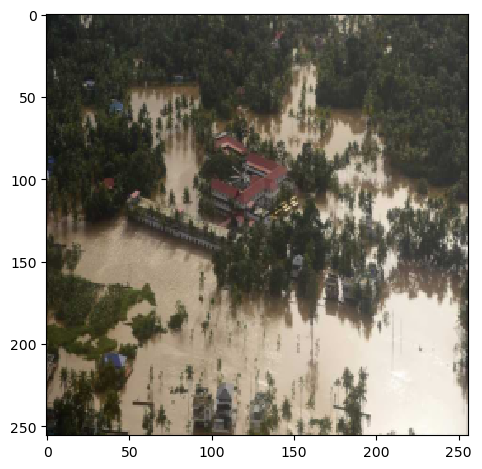

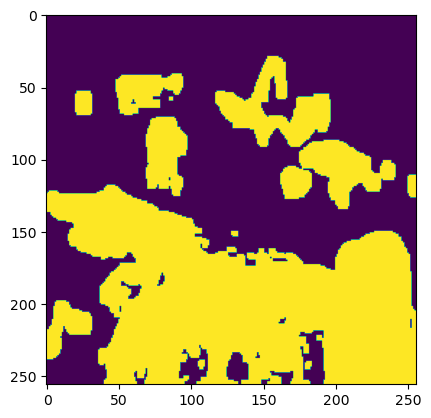

In [ ]:
# Plotting random images and their mask

import random
image_x = random.randint(0, len(images_ids))
imshow(X[image_x])
plt.show()
plt.imshow(np.squeeze(Y[image_x]))

In [ ]:
# The custom U-Net Architecture

# Input image
input = tf.keras.layers.Input((256, 256, 3))

# reduce image config
s = tf.keras.layers.Lambda(lambda x: x / 256)(input)

# block 1
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation="relu", kernel_initializer='he_normal', padding='same')(s)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)

# block 2
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)

# block 3
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
c3  = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)

# block 4
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPooling2D((2, 2))(c4)

# block 5
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
c5 = tf.keras.layers.Dropout(0.3)(c5)
c5 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
p5 = tf.keras.layers.MaxPooling2D((2, 2))(c5)

# block 6
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p5)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
c6 = tf.keras.layers.Dropout(0.3)(c6)
c6 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

# block 7 - back 1
u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c5])
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
c7 = tf.keras.layers.Dropout(0.3)(c7)
c7 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

# block 8 - back 2
u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c4])
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
c8 = tf.keras.layers.Dropout(0.2)(c8)
c8 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

# block 9 - back 3
u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c3])
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
c9 = tf.keras.layers.Dropout(0.2)(c9)
c9 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

# block 10 - back 4
u10 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c9)
u10 = tf.keras.layers.concatenate([u10, c2])
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)
c10 = tf.keras.layers.Dropout(0.1)(c10)
c10 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c10)

# block 11 - back 5
u11 = tf.keras.layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c10)
u11 = tf.keras.layers.concatenate([u11, c1])
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)
c11 = tf.keras.layers.Dropout(0.1)(c11)
c11 = tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c11)

outputs = tf.keras.layers.Conv2D(1, (1, 1), activation='sigmoid')(c11)

modelUNet = tf.keras.Model(inputs=input, outputs=outputs, name='U-NET')

modelUNet.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
modelUNet.summary()

Model: "U-NET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 256, 256, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [ ]:
callbacks=[
#     tf.keras.callbacks.EarlyStopping(patience=2, monitor="val_loss"),
    tf.keras.callbacks.TensorBoard(log_dir="logs")]


results = modelUNet.fit(X, Y, validation_split=0.1, batch_size=8, epochs=50, callbacks=callbacks)

Epoch 1/50
33/33 [==============================] - 180s 5s/step - loss: 0.6379 - accuracy: 0.6419 - val_loss: 0.5316 - val_accuracy: 0.7468
Epoch 2/50
33/33 [==============================] - 174s 5s/step - loss: 0.5550 - accuracy: 0.7547 - val_loss: 0.5141 - val_accuracy: 0.7666
Epoch 3/50
33/33 [==============================] - 174s 5s/step - loss: 0.5231 - accuracy: 0.7582 - val_loss: 0.4713 - val_accuracy: 0.7899
Epoch 4/50
33/33 [==============================] - 174s 5s/step - loss: 0.5009 - accuracy: 0.7764 - val_loss: 0.4499 - val_accuracy: 0.8045
Epoch 5/50
33/33 [==============================] - 174s 5s/step - loss: 0.4847 - accuracy: 0.7819 - val_loss: 0.5924 - val_accuracy: 0.7150
Epoch 6/50
33/33 [==============================] - 174s 5s/step - loss: 0.4577 - accuracy: 0.7965 - val_loss: 0.4109 - val_accuracy: 0.8340
Epoch 7/50
33/33 [==============================] - 173s 5s/step - loss: 0.4510 - accuracy: 0.8048 - val_loss: 0.4918 - val_accuracy: 0.7785
Epoch 8/50
33

In [ ]:
# Function to plot the training curve with the best model indication

def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

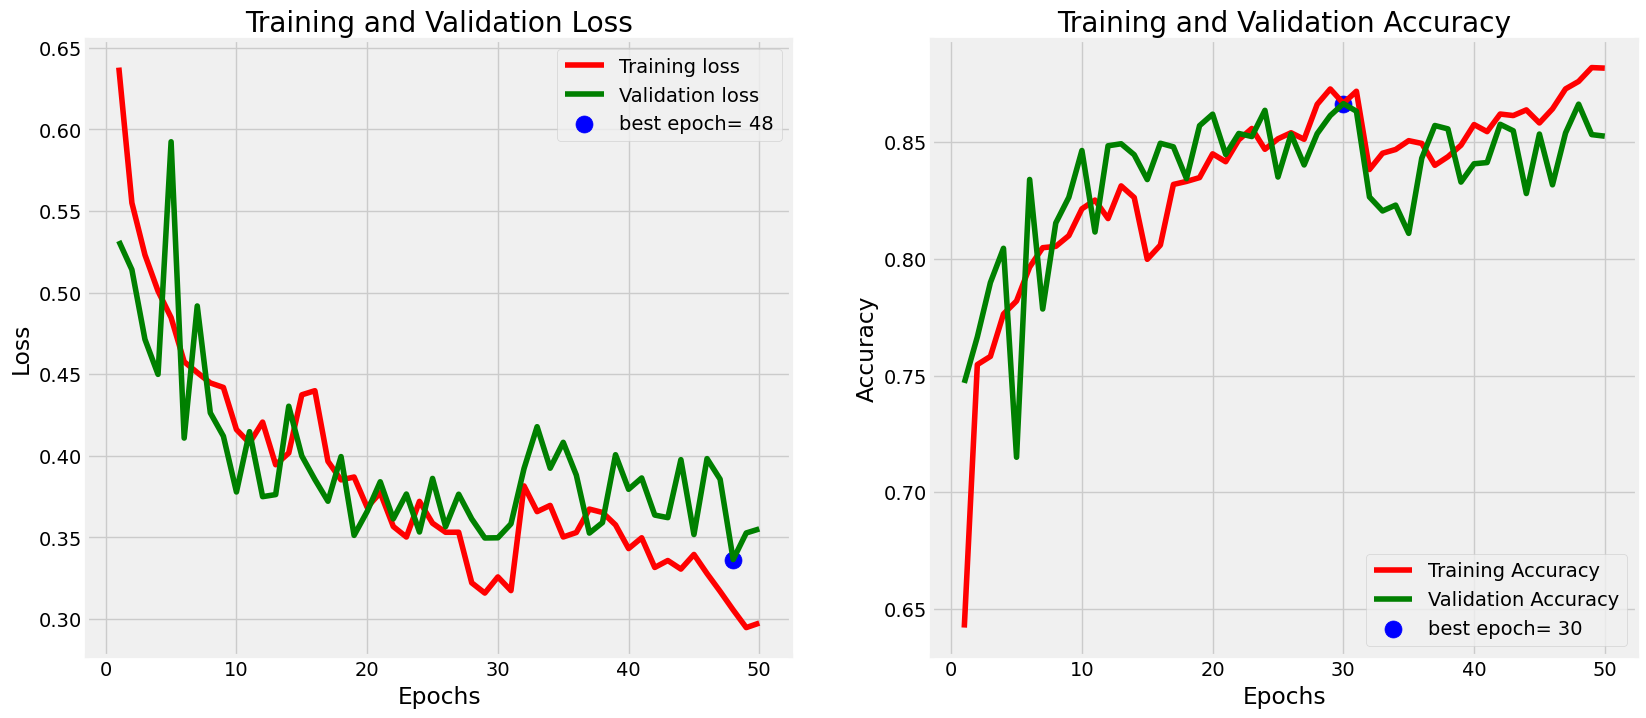

In [ ]:
plot_training(results)

In [ ]:
# Evaluate the model

modelUNet.evaluate(X, Y)

10/10 [==============================] - 43s 4s/step - loss: 0.3173 - accuracy: 0.8664


[0.3172535002231598, 0.8663883209228516]

<Figure size 3000x3000 with 0 Axes>

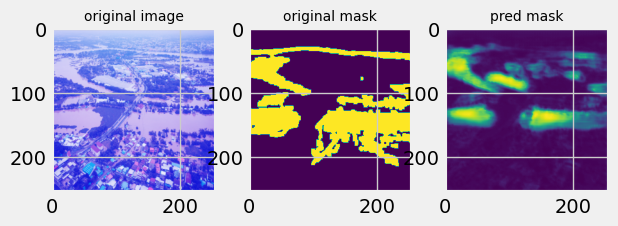

In [ ]:
# displaying random image, mask, and predicted mask

plt.figure(figsize=(30,30))

ind = random.randint(0, len(X))
img = X[ind]
predMask = modelUNet.predict(np.expand_dims(img, axis=0), verbose=0)
fig = plt.figure()
ax1 = fig.add_subplot(1, 3, 1)
ax1.set_title("original image", fontdict = {'fontsize' : 10})
ax1.imshow(X[ind])
ax2 = fig.add_subplot(1, 3, 2)
ax2.set_title("original mask", fontdict = {'fontsize' : 10})
ax2.imshow(np.squeeze(Y[ind]))
ax3 = fig.add_subplot(1, 3, 3)
ax3.set_title("pred mask", fontdict = {'fontsize' : 10})
ax3.imshow(np.squeeze(predMask))

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flood-area-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2738852%2F4732950%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T184853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6297943c7386c2f34e4ba2e04315c7bf06c26e35335c0be129550eb02fd9d19a61f5810ba1678906686ccf31461592f46ad7c02b66763440422be28cc81923f629bda1a608f426c63f07937383df61f5214d5f97ee1f4ef5fa4af00369afe33f6e60beab678afc796a62e697be0bd6397fe9861a92ec259f52eb8e256c0267020a7f17fb10273de621851ab2cd634de301cff99e2c32959b5a02948aaa8f329335dd011cb0df98cec42093f6e0f143da488bb091e3992b82177b9132a6daa28f648c047adb9c10d210f729e853d4f6adc4e8adbaae56068217459f027e24c9b749671dfbabdc42a634f54243843c1f42598ec1830b70b9c0e47920398687c4fb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 112072442 bytes downloaded
Downloaded and uncompressed: flood-area-segmentation
Data source import complete.


In [ ]:
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from os import listdir
import pandas as pd
from keras.layers import Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Activation, Concatenate
from tensorflow import keras
from time import time
from tqdm import tqdm
from keras import backend as K

np.__version__

'1.25.2'

In [ ]:
!pip install segmentation_models
!pip install  -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.9 MB/s eta 0:00:00


Notes:
>**segmentation_models:>**
This is a Python library used for image segmentation tasks. Image segmentation is a process in computer vision where the goal is to classify each pixel of an image into a specific category. The segmentation_models library provides pre-trained models and utilities to make it easier to build and train segmentation models.

>**albumentations:**
This is a fast image augmentation library. Image augmentation involves applying random transformations to images, such as rotation, scaling, flipping, etc., to create more varied data from existing images. This helps improve the generalization ability of machine learning models by making them robust to various changes and distortions in the input data.

**Key Features of segmentation_models:**

* Pre-Built Models: Provides several popular segmentation architectures out of the box, such as **U-Net**, **FPN** (Feature Pyramid Networks), and **LinkNet**. These models are commonly used for tasks like semantic segmentation and instance segmentation.
Backbones:

* Supports various backbones for feature extraction, including popular architectures like**VGG16, ResNet, and EfficientNet**. These backbones are used to extract features from the input images before the segmentation head processes them.

In [ ]:
%env SM_FRAMEWORK = tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
PATH = '/kaggle/input/flood-area-segmentation/'

df = pd.read_csv(PATH + 'metadata.csv')
df.head()

Image   Mask
0  0.jpg  0.png
1  1.jpg  1.png
2  2.jpg  2.png
3  3.jpg  3.png
4  4.jpg  4.png

In [ ]:
import segmentation_models as sm
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit = 3, p = 0.5),
    # A.RandomRotate90(p=1) ,
    # A.Rotate(limit=90,p=0.5) ,
    # A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

])

Segmentation Models: using `tf.keras` framework.


**Note:**
>
* Horizontal Flip: Flipping an image horizontally can create a mirror image, which can be helpful for recognizing objects from different angles.

* Blur: Applying blur can simulate different depths of field and out-of-focus effects, making the model more robust to variations in image clarity.

* RandomRotate90 (commented): Rotates the image by 90 degrees randomly, which can help with recognizing objects in various orientations.

* Rotate (commented): Rotates the image by a random degree within the specified limit. This can help the model learn to recognize objects that may appear at different angles.

* ElasticTransform (commented): Applies elastic deformation to the image, which can be useful for augmenting images to simulate natural distortions.

In [ ]:
df['Image'] = df['Image'].map(lambda x: PATH + 'Image/' + x)
df['Mask'] = df['Mask'].map(lambda x: PATH + 'Mask/' + x)


In [ ]:
df

Image  \
0    /kaggle/input/flood-area-segmentation/Image/0.jpg   
1    /kaggle/input/flood-area-segmentation/Image/1.jpg   
2    /kaggle/input/flood-area-segmentation/Image/2.jpg   
3    /kaggle/input/flood-area-segmentation/Image/3.jpg   
4    /kaggle/input/flood-area-segmentation/Image/4.jpg   
..                                                 ...   
285  /kaggle/input/flood-area-segmentation/Image/10...   
286  /kaggle/input/flood-area-segmentation/Image/10...   
287  /kaggle/input/flood-area-segmentation/Image/10...   
288  /kaggle/input/flood-area-segmentation/Image/10...   
289  /kaggle/input/flood-area-segmentation/Image/10...   

                                                  Mask  
0     /kaggle/input/flood-area-segmentation/Mask/0.png  
1     /kaggle/input/flood-area-segmentation/Mask/1.png  
2     /kaggle/input/flood-area-segmentation/Mask/2.png  
3     /kaggle/input/flood-area-segmentation/Mask/3.png  
4     /kaggle/input/flood-area-segmentation/Mask/4.png  
..                                                 ...  
285  /kaggle/input/flood-area-segmentation/Mask/108...  
286  /kaggle/input/flood-area-segmentation/Mask/108...  
287  /kaggle/input/flood-area-segmentation/Mask/108...  
288  /kaggle/input/flood-area-segmentation/Mask/108...  
289  /kaggle/input/flood-area-segmentation/Mask/108...  

[290 rows x 2 columns]

✈ **show  image  sizes**

In [ ]:
import pandas as pd
from PIL import Image

df = pd.DataFrame(df)

# Function to get image size
def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            return img.size
    except IOError:
        return (None, None)

# Apply function to DataFrame to get image sizes
df['Image_Size'] = df['Image'].apply(get_image_size)
df['Mask_Size'] = df['Mask'].apply(get_image_size)

# Split the size tuple into separate columns for width and height
df['Image_Width'], df['Image_Height'] = zip(*df['Image_Size'])
df['Mask_Width'], df['Mask_Height'] = zip(*df['Mask_Size'])

# Drop the size columns if you only want width and height
df.drop(columns=['Image_Size', 'Mask_Size'], inplace=True)

df


Image  \
0    /kaggle/input/flood-area-segmentation/Image/0.jpg   
1    /kaggle/input/flood-area-segmentation/Image/1.jpg   
2    /kaggle/input/flood-area-segmentation/Image/2.jpg   
3    /kaggle/input/flood-area-segmentation/Image/3.jpg   
4    /kaggle/input/flood-area-segmentation/Image/4.jpg   
..                                                 ...   
285  /kaggle/input/flood-area-segmentation/Image/10...   
286  /kaggle/input/flood-area-segmentation/Image/10...   
287  /kaggle/input/flood-area-segmentation/Image/10...   
288  /kaggle/input/flood-area-segmentation/Image/10...   
289  /kaggle/input/flood-area-segmentation/Image/10...   

                                                  Mask  Image_Width  \
0     /kaggle/input/flood-area-segmentation/Mask/0.png          893   
1     /kaggle/input/flood-area-segmentation/Mask/1.png          500   
2     /kaggle/input/flood-area-segmentation/Mask/2.png          640   
3     /kaggle/input/flood-area-segmentation/Mask/3.png          798   
4     /kaggle/input/flood-area-segmentation/Mask/4.png          626   
..                                                 ...          ...   
285  /kaggle/input/flood-area-segmentation/Mask/108...          600   
286  /kaggle/input/flood-area-segmentation/Mask/108...         5184   
287  /kaggle/input/flood-area-segmentation/Mask/108...          650   
288  /kaggle/input/flood-area-segmentation/Mask/108...         1232   
289  /kaggle/input/flood-area-segmentation/Mask/108...          600   

     Image_Height  Mask_Width  Mask_Height  
0             551         893          551  
1             300         500          300  
2             450         640          450  
3             296         798          296  
4             470         626          470  
..            ...         ...          ...  
285           338         600          338  
286          3456        5184         3456  
287           433         650          433  
288           821        1232          821  
289           314         600          314  

[290 rows x 6 columns]

['/kaggle/input/flood-area-segmentation/Image/5.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/5.png']


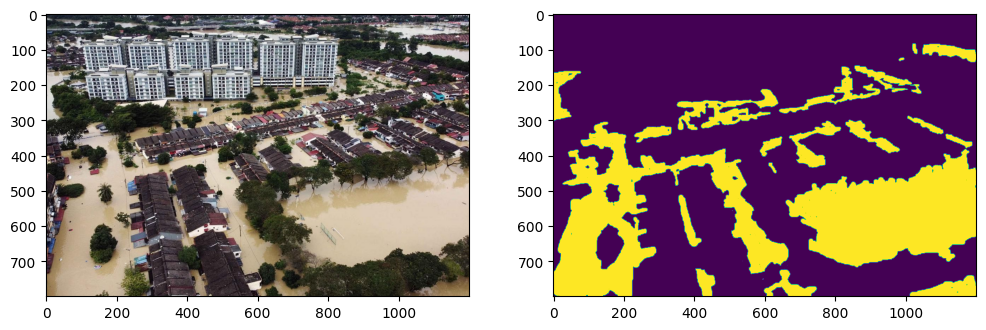

['/kaggle/input/flood-area-segmentation/Image/24.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/24.png']


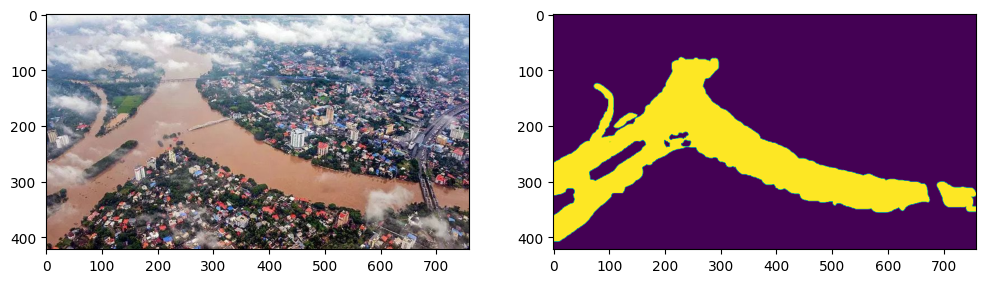

['/kaggle/input/flood-area-segmentation/Image/3059.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3059.png']


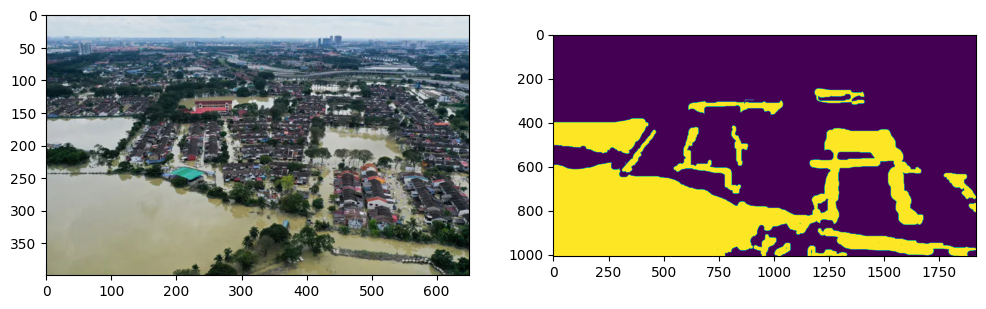

['/kaggle/input/flood-area-segmentation/Image/2040.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/2040.png']


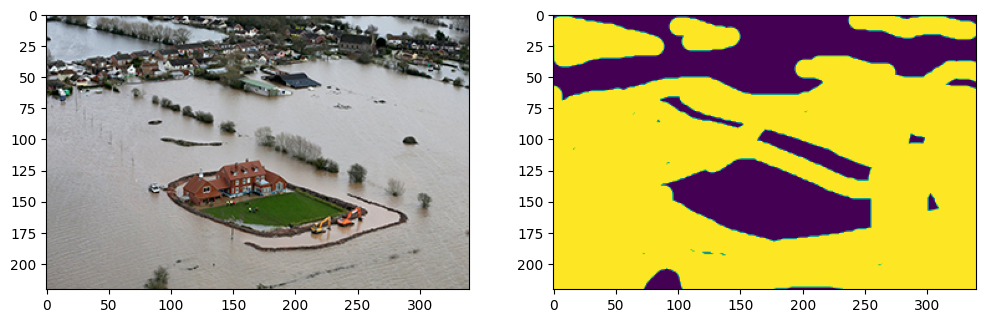

['/kaggle/input/flood-area-segmentation/Image/1073.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/1073.png']


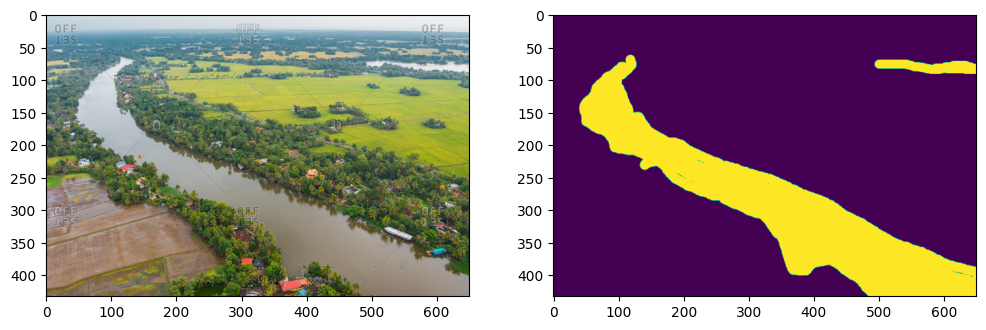

In [ ]:
for i in range(5):
    sample = df.sample(n = 1)
    print(sample['Image'].values, sample['Mask'].values)

    img = plt.imread(sample.iloc[0,0], 0)
    mask = plt.imread(sample.iloc[0, 1], 0)

    plt.figure(figsize = (12,8))
    plt.subplot(1,2,1)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.imshow(mask)

    img.shape, mask.shape

    plt.show()

**Image preprocessing**

In [ ]:
IMG_SIZE = (224, 224)

def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=0.5, 1)
    return t_mask

def map_function(img, mask, training):
    img, mask = plt.imread(img.decode())[:, :, :3], plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = modify_mask(op.resize(mask, IMG_SIZE))

    img = img/255.0
    if training == True:
        transformed = transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

    return img.astype(np.float64), mask.astype(np.float64)

In [ ]:
BATCH_SIZE = 16

def create_dataset(data, training = True):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(100)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask, training], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.1)

print(df_train.shape, df_test.shape)
train_dataset = create_dataset(df_train, training = True)
test_dataset = create_dataset(df_test, training = False)


(261, 2) (29, 2)


In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
model = sm.Unet('efficientnetb2',
                input_shape = (224,224,3),
                classes = 1,
                activation='sigmoid',
                encoder_weights='imagenet')

31936256/31936256 [==============================] - 0s 0us/step


In [ ]:
 model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]']         

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 2e-4),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [sm.metrics.iou_score],
)

In [ ]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 50)

Epoch 1/50
17/17 [==============================] - 36s 2s/step - loss: 0.0930 - iou_score: 0.8662 - val_loss: 0.3705 - val_iou_score: 0.7294
Epoch 2/50
17/17 [==============================] - 36s 2s/step - loss: 0.0883 - iou_score: 0.8669 - val_loss: 0.3939 - val_iou_score: 0.7496
Epoch 3/50
17/17 [==============================] - 36s 2s/step - loss: 0.0865 - iou_score: 0.8716 - val_loss: 0.3780 - val_iou_score: 0.7547
Epoch 4/50
17/17 [==============================] - 36s 2s/step - loss: 0.0874 - iou_score: 0.8734 - val_loss: 0.3979 - val_iou_score: 0.7524
Epoch 5/50
17/17 [==============================] - 36s 2s/step - loss: 0.0847 - iou_score: 0.8751 - val_loss: 0.3774 - val_iou_score: 0.7579
Epoch 6/50
17/17 [==============================] - 36s 2s/step - loss: 0.0824 - iou_score: 0.8744 - val_loss: 0.3744 - val_iou_score: 0.7529
Epoch 7/50
17/17 [==============================] - 37s 2s/step - loss: 0.0836 - iou_score: 0.8692 - val_loss: 0.3953 - val_iou_score: 0.7510
Epoch 

<ipython-input-27-9293f450f3f8>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


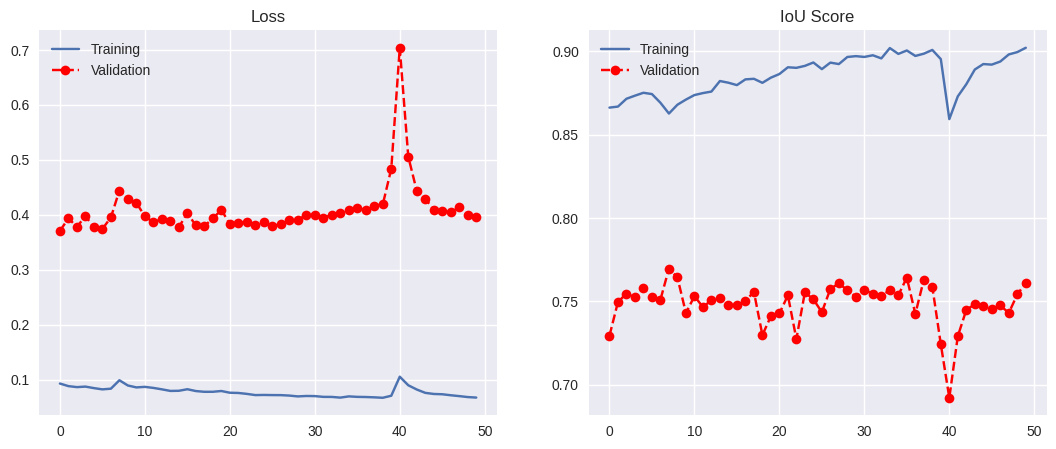

In [ ]:
plt.style.use('seaborn')

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], '--r', marker = 'o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('IoU Score')
plt.plot(history.history['iou_score'], label = 'Training')
plt.plot(history.history['val_iou_score'], '--r', marker = 'o', label = 'Validation')
plt.legend()


In [ ]:
color = np.array([161, 205, 255])/255.0

def make_pred_good(pred):
    pred = pred[0][:, :, :]
    pred = modify_mask(pred[:, :, 0])
    pred = np.repeat(pred, 3, 2)
    return pred

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

(-0.5, 223.5, 223.5, -0.5)

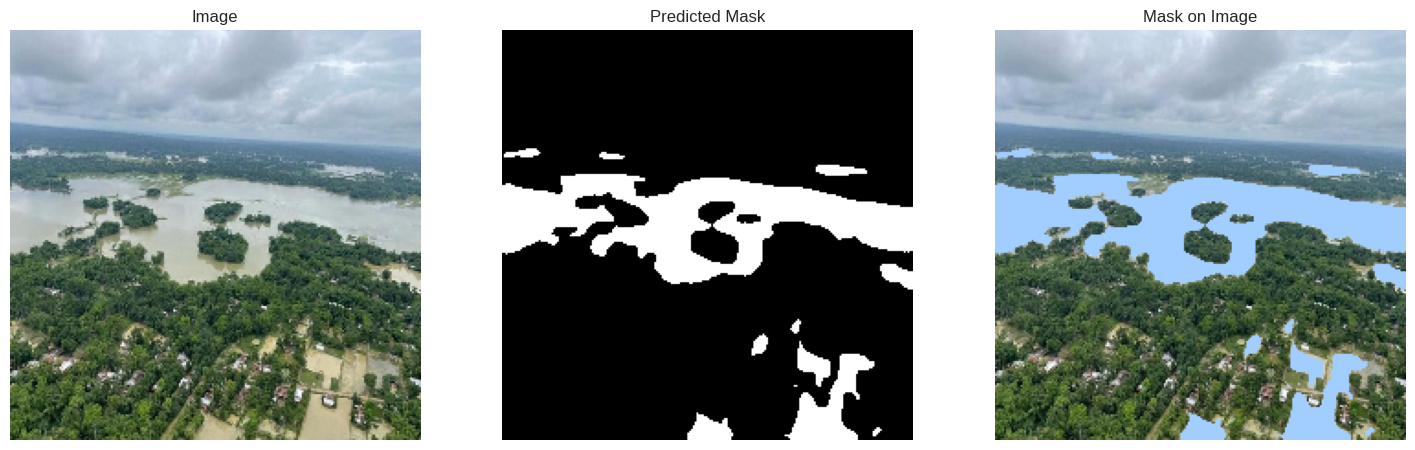

In [ ]:
url ='https://i.tribune.com.pk/media/images/Floods1656337686-1/Floods1656337686-1.jpg'
import requests, io
import numpy as np
from PIL import Image

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im))[:, :, :3]

img = img/255.0
img = op.resize(img, (224,224))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Mask on Image")
plt.imshow(placeMaskOnImg(img[0], pred))
plt.axis('off')

# pred = model(img).numpy()
# plt.imshow(pred.reshape(224, 224))

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flood-area-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2738852%2F4732950%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T184853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6297943c7386c2f34e4ba2e04315c7bf06c26e35335c0be129550eb02fd9d19a61f5810ba1678906686ccf31461592f46ad7c02b66763440422be28cc81923f629bda1a608f426c63f07937383df61f5214d5f97ee1f4ef5fa4af00369afe33f6e60beab678afc796a62e697be0bd6397fe9861a92ec259f52eb8e256c0267020a7f17fb10273de621851ab2cd634de301cff99e2c32959b5a02948aaa8f329335dd011cb0df98cec42093f6e0f143da488bb091e3992b82177b9132a6daa28f648c047adb9c10d210f729e853d4f6adc4e8adbaae56068217459f027e24c9b749671dfbabdc42a634f54243843c1f42598ec1830b70b9c0e47920398687c4fb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 112072442 bytes downloaded
Downloaded and uncompressed: flood-area-segmentation
Data source import complete.


In [ ]:
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from os import listdir
import pandas as pd
from keras.layers import Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Activation, Concatenate
from tensorflow import keras
from time import time
from tqdm import tqdm
from keras import backend as K

np.__version__

'1.25.2'

In [ ]:
!pip install segmentation_models
!pip install  -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.9 MB/s eta 0:00:00


Notes:
>**segmentation_models:>**
This is a Python library used for image segmentation tasks. Image segmentation is a process in computer vision where the goal is to classify each pixel of an image into a specific category. The segmentation_models library provides pre-trained models and utilities to make it easier to build and train segmentation models.

>**albumentations:**
This is a fast image augmentation library. Image augmentation involves applying random transformations to images, such as rotation, scaling, flipping, etc., to create more varied data from existing images. This helps improve the generalization ability of machine learning models by making them robust to various changes and distortions in the input data.

**Key Features of segmentation_models:**

* Pre-Built Models: Provides several popular segmentation architectures out of the box, such as **U-Net**, **FPN** (Feature Pyramid Networks), and **LinkNet**. These models are commonly used for tasks like semantic segmentation and instance segmentation.
Backbones:

* Supports various backbones for feature extraction, including popular architectures like**VGG16, ResNet, and EfficientNet**. These backbones are used to extract features from the input images before the segmentation head processes them.

In [ ]:
%env SM_FRAMEWORK = tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
PATH = '/kaggle/input/flood-area-segmentation/'

df = pd.read_csv(PATH + 'metadata.csv')
df.head()

Image   Mask
0  0.jpg  0.png
1  1.jpg  1.png
2  2.jpg  2.png
3  3.jpg  3.png
4  4.jpg  4.png

In [ ]:
import segmentation_models as sm
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit = 3, p = 0.5),
    # A.RandomRotate90(p=1) ,
    # A.Rotate(limit=90,p=0.5) ,
    # A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

])

Segmentation Models: using `tf.keras` framework.


**Note:**
>
* Horizontal Flip: Flipping an image horizontally can create a mirror image, which can be helpful for recognizing objects from different angles.

* Blur: Applying blur can simulate different depths of field and out-of-focus effects, making the model more robust to variations in image clarity.

* RandomRotate90 (commented): Rotates the image by 90 degrees randomly, which can help with recognizing objects in various orientations.

* Rotate (commented): Rotates the image by a random degree within the specified limit. This can help the model learn to recognize objects that may appear at different angles.

* ElasticTransform (commented): Applies elastic deformation to the image, which can be useful for augmenting images to simulate natural distortions.

In [ ]:
df['Image'] = df['Image'].map(lambda x: PATH + 'Image/' + x)
df['Mask'] = df['Mask'].map(lambda x: PATH + 'Mask/' + x)


In [ ]:
df

Image  \
0    /kaggle/input/flood-area-segmentation/Image/0.jpg   
1    /kaggle/input/flood-area-segmentation/Image/1.jpg   
2    /kaggle/input/flood-area-segmentation/Image/2.jpg   
3    /kaggle/input/flood-area-segmentation/Image/3.jpg   
4    /kaggle/input/flood-area-segmentation/Image/4.jpg   
..                                                 ...   
285  /kaggle/input/flood-area-segmentation/Image/10...   
286  /kaggle/input/flood-area-segmentation/Image/10...   
287  /kaggle/input/flood-area-segmentation/Image/10...   
288  /kaggle/input/flood-area-segmentation/Image/10...   
289  /kaggle/input/flood-area-segmentation/Image/10...   

                                                  Mask  
0     /kaggle/input/flood-area-segmentation/Mask/0.png  
1     /kaggle/input/flood-area-segmentation/Mask/1.png  
2     /kaggle/input/flood-area-segmentation/Mask/2.png  
3     /kaggle/input/flood-area-segmentation/Mask/3.png  
4     /kaggle/input/flood-area-segmentation/Mask/4.png  
..                                                 ...  
285  /kaggle/input/flood-area-segmentation/Mask/108...  
286  /kaggle/input/flood-area-segmentation/Mask/108...  
287  /kaggle/input/flood-area-segmentation/Mask/108...  
288  /kaggle/input/flood-area-segmentation/Mask/108...  
289  /kaggle/input/flood-area-segmentation/Mask/108...  

[290 rows x 2 columns]

✈ **show  image  sizes**

In [ ]:
import pandas as pd
from PIL import Image

df = pd.DataFrame(df)

# Function to get image size
def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            return img.size
    except IOError:
        return (None, None)

# Apply function to DataFrame to get image sizes
df['Image_Size'] = df['Image'].apply(get_image_size)
df['Mask_Size'] = df['Mask'].apply(get_image_size)

# Split the size tuple into separate columns for width and height
df['Image_Width'], df['Image_Height'] = zip(*df['Image_Size'])
df['Mask_Width'], df['Mask_Height'] = zip(*df['Mask_Size'])

# Drop the size columns if you only want width and height
df.drop(columns=['Image_Size', 'Mask_Size'], inplace=True)

df


Image  \
0    /kaggle/input/flood-area-segmentation/Image/0.jpg   
1    /kaggle/input/flood-area-segmentation/Image/1.jpg   
2    /kaggle/input/flood-area-segmentation/Image/2.jpg   
3    /kaggle/input/flood-area-segmentation/Image/3.jpg   
4    /kaggle/input/flood-area-segmentation/Image/4.jpg   
..                                                 ...   
285  /kaggle/input/flood-area-segmentation/Image/10...   
286  /kaggle/input/flood-area-segmentation/Image/10...   
287  /kaggle/input/flood-area-segmentation/Image/10...   
288  /kaggle/input/flood-area-segmentation/Image/10...   
289  /kaggle/input/flood-area-segmentation/Image/10...   

                                                  Mask  Image_Width  \
0     /kaggle/input/flood-area-segmentation/Mask/0.png          893   
1     /kaggle/input/flood-area-segmentation/Mask/1.png          500   
2     /kaggle/input/flood-area-segmentation/Mask/2.png          640   
3     /kaggle/input/flood-area-segmentation/Mask/3.png          798   
4     /kaggle/input/flood-area-segmentation/Mask/4.png          626   
..                                                 ...          ...   
285  /kaggle/input/flood-area-segmentation/Mask/108...          600   
286  /kaggle/input/flood-area-segmentation/Mask/108...         5184   
287  /kaggle/input/flood-area-segmentation/Mask/108...          650   
288  /kaggle/input/flood-area-segmentation/Mask/108...         1232   
289  /kaggle/input/flood-area-segmentation/Mask/108...          600   

     Image_Height  Mask_Width  Mask_Height  
0             551         893          551  
1             300         500          300  
2             450         640          450  
3             296         798          296  
4             470         626          470  
..            ...         ...          ...  
285           338         600          338  
286          3456        5184         3456  
287           433         650          433  
288           821        1232          821  
289           314         600          314  

[290 rows x 6 columns]

['/kaggle/input/flood-area-segmentation/Image/5.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/5.png']


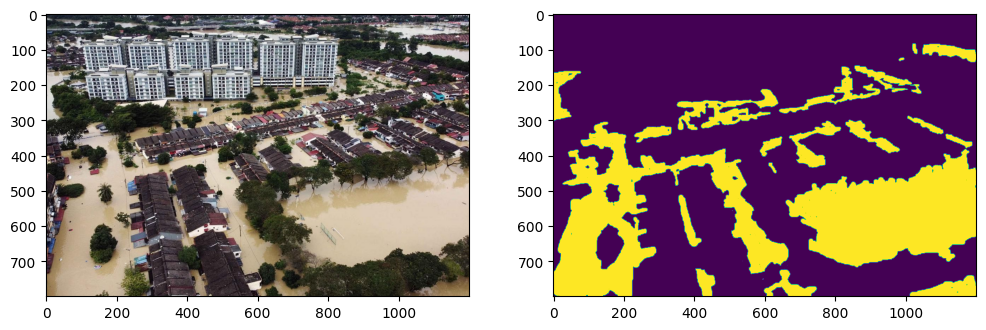

['/kaggle/input/flood-area-segmentation/Image/24.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/24.png']


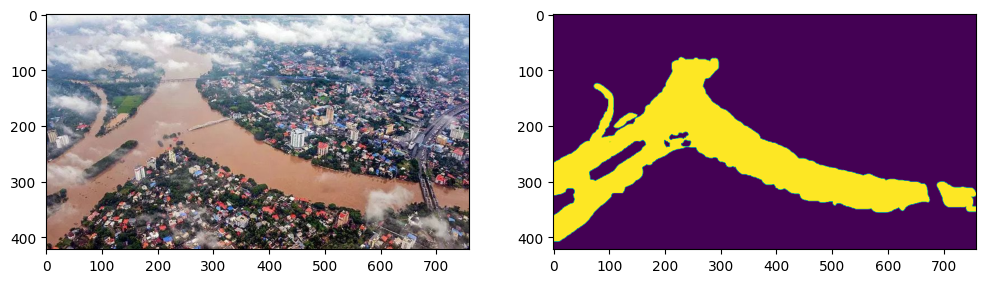

['/kaggle/input/flood-area-segmentation/Image/3059.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3059.png']


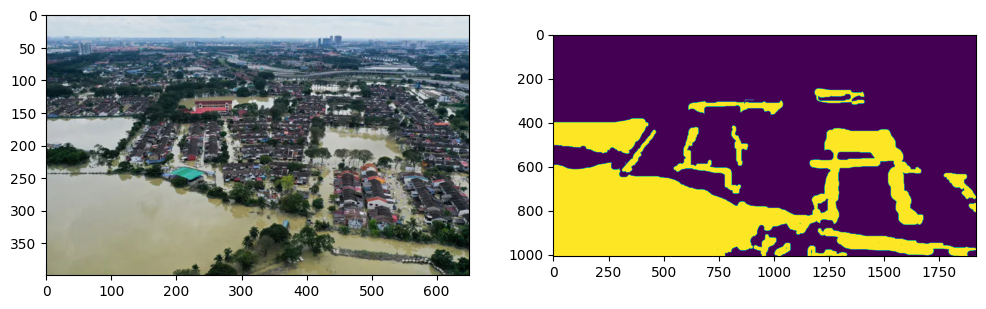

['/kaggle/input/flood-area-segmentation/Image/2040.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/2040.png']


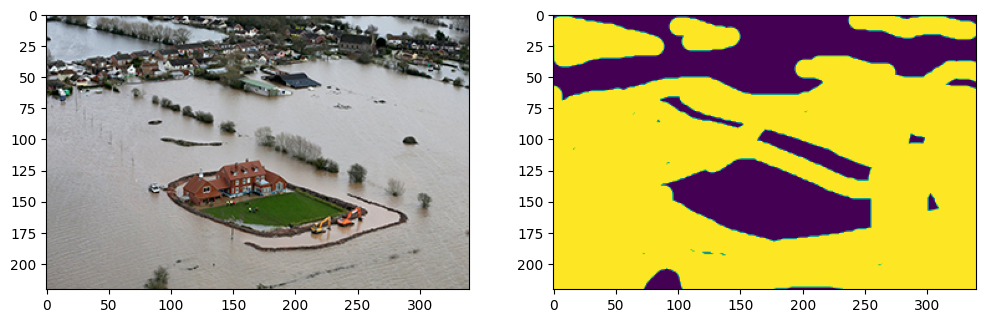

['/kaggle/input/flood-area-segmentation/Image/1073.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/1073.png']


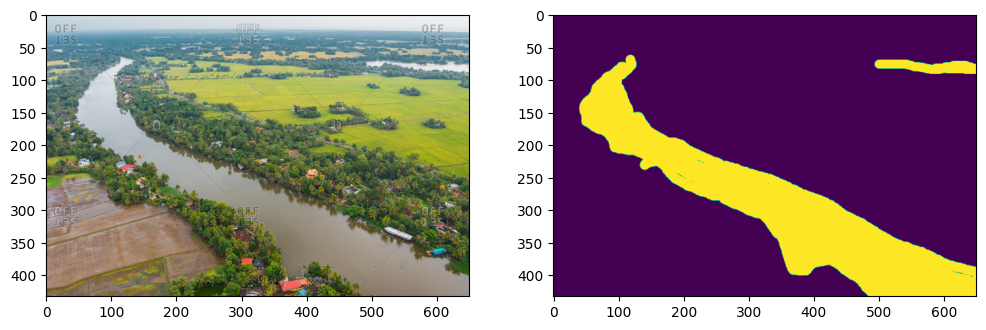

In [ ]:
for i in range(5):
    sample = df.sample(n = 1)
    print(sample['Image'].values, sample['Mask'].values)

    img = plt.imread(sample.iloc[0,0], 0)
    mask = plt.imread(sample.iloc[0, 1], 0)

    plt.figure(figsize = (12,8))
    plt.subplot(1,2,1)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.imshow(mask)

    img.shape, mask.shape

    plt.show()

**Image preprocessing**

In [ ]:
IMG_SIZE = (224, 224)

def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=0.5, 1)
    return t_mask

def map_function(img, mask, training):
    img, mask = plt.imread(img.decode())[:, :, :3], plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = modify_mask(op.resize(mask, IMG_SIZE))

    img = img/255.0
    if training == True:
        transformed = transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

    return img.astype(np.float64), mask.astype(np.float64)

In [ ]:
BATCH_SIZE = 16

def create_dataset(data, training = True):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(100)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask, training], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.1)

print(df_train.shape, df_test.shape)
train_dataset = create_dataset(df_train, training = True)
test_dataset = create_dataset(df_test, training = False)


(261, 2) (29, 2)


In [ ]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
model = sm.Unet('efficientnetb2',
                input_shape = (224,224,3),
                classes = 1,
                activation='sigmoid',
                encoder_weights='imagenet')

31936256/31936256 [==============================] - 0s 0us/step


In [ ]:
 model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]']         

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 2e-4),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [sm.metrics.iou_score],
)

In [ ]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 50)

Epoch 1/50
17/17 [==============================] - 36s 2s/step - loss: 0.0930 - iou_score: 0.8662 - val_loss: 0.3705 - val_iou_score: 0.7294
Epoch 2/50
17/17 [==============================] - 36s 2s/step - loss: 0.0883 - iou_score: 0.8669 - val_loss: 0.3939 - val_iou_score: 0.7496
Epoch 3/50
17/17 [==============================] - 36s 2s/step - loss: 0.0865 - iou_score: 0.8716 - val_loss: 0.3780 - val_iou_score: 0.7547
Epoch 4/50
17/17 [==============================] - 36s 2s/step - loss: 0.0874 - iou_score: 0.8734 - val_loss: 0.3979 - val_iou_score: 0.7524
Epoch 5/50
17/17 [==============================] - 36s 2s/step - loss: 0.0847 - iou_score: 0.8751 - val_loss: 0.3774 - val_iou_score: 0.7579
Epoch 6/50
17/17 [==============================] - 36s 2s/step - loss: 0.0824 - iou_score: 0.8744 - val_loss: 0.3744 - val_iou_score: 0.7529
Epoch 7/50
17/17 [==============================] - 37s 2s/step - loss: 0.0836 - iou_score: 0.8692 - val_loss: 0.3953 - val_iou_score: 0.7510
Epoch 

<ipython-input-27-9293f450f3f8>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


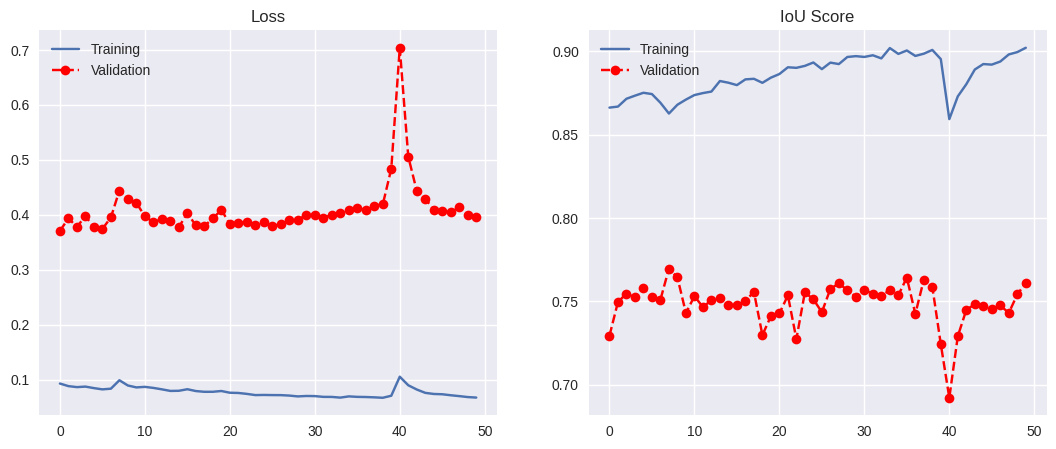

In [ ]:
plt.style.use('seaborn')

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], '--r', marker = 'o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('IoU Score')
plt.plot(history.history['iou_score'], label = 'Training')
plt.plot(history.history['val_iou_score'], '--r', marker = 'o', label = 'Validation')
plt.legend()


In [ ]:
color = np.array([161, 205, 255])/255.0

def make_pred_good(pred):
    pred = pred[0][:, :, :]
    pred = modify_mask(pred[:, :, 0])
    pred = np.repeat(pred, 3, 2)
    return pred

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

(-0.5, 223.5, 223.5, -0.5)

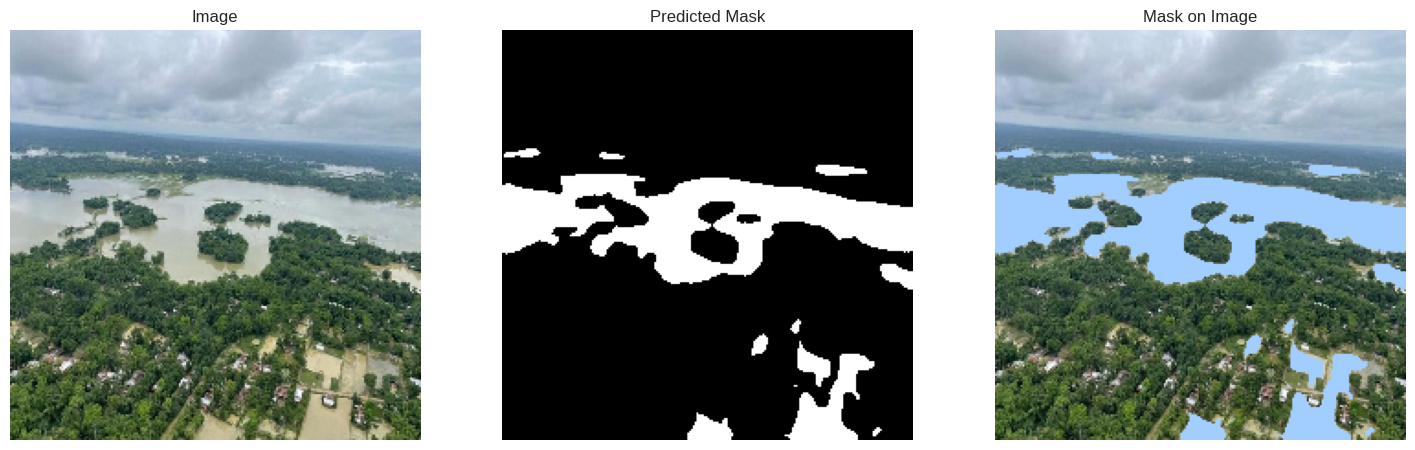

In [ ]:
url ='https://i.tribune.com.pk/media/images/Floods1656337686-1/Floods1656337686-1.jpg'
import requests, io
import numpy as np
from PIL import Image

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im))[:, :, :3]

img = img/255.0
img = op.resize(img, (224,224))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Mask on Image")
plt.imshow(placeMaskOnImg(img[0], pred))
plt.axis('off')

# pred = model(img).numpy()
# plt.imshow(pred.reshape(224, 224))

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'flood-area-segmentation:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F2738852%2F4732950%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240726%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240726T184853Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D6297943c7386c2f34e4ba2e04315c7bf06c26e35335c0be129550eb02fd9d19a61f5810ba1678906686ccf31461592f46ad7c02b66763440422be28cc81923f629bda1a608f426c63f07937383df61f5214d5f97ee1f4ef5fa4af00369afe33f6e60beab678afc796a62e697be0bd6397fe9861a92ec259f52eb8e256c0267020a7f17fb10273de621851ab2cd634de301cff99e2c32959b5a02948aaa8f329335dd011cb0df98cec42093f6e0f143da488bb091e3992b82177b9132a6daa28f648c047adb9c10d210f729e853d4f6adc4e8adbaae56068217459f027e24c9b749671dfbabdc42a634f54243843c1f42598ec1830b70b9c0e47920398687c4fb'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 112072442 bytes downloaded
Downloaded and uncompressed: flood-area-segmentation
Data source import complete.


In [ ]:
import os
import sys
import numpy as np
import re
import cv2 as op
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
from os import listdir
import pandas as pd
from keras.layers import Dense, Dropout, Input, add, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose,Activation, Concatenate
from tensorflow import keras
from time import time
from tqdm import tqdm
from keras import backend as K

np.__version__

'1.25.2'

In [ ]:
!pip install segmentation_models
!pip install  -U albumentations

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.3/165.3 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.9 MB/s eta 0:00:00


Notes:
>**segmentation_models:>**
This is a Python library used for image segmentation tasks. Image segmentation is a process in computer vision where the goal is to classify each pixel of an image into a specific category. The segmentation_models library provides pre-trained models and utilities to make it easier to build and train segmentation models.

>**albumentations:**
This is a fast image augmentation library. Image augmentation involves applying random transformations to images, such as rotation, scaling, flipping, etc., to create more varied data from existing images. This helps improve the generalization ability of machine learning models by making them robust to various changes and distortions in the input data.

**Key Features of segmentation_models:**

* Pre-Built Models: Provides several popular segmentation architectures out of the box, such as **U-Net**, **FPN** (Feature Pyramid Networks), and **LinkNet**. These models are commonly used for tasks like semantic segmentation and instance segmentation.
Backbones:

* Supports various backbones for feature extraction, including popular architectures like**VGG16, ResNet, and EfficientNet**. These backbones are used to extract features from the input images before the segmentation head processes them.

In [ ]:
%env SM_FRAMEWORK = tf.keras

env: SM_FRAMEWORK=tf.keras


In [ ]:
PATH = '/kaggle/input/flood-area-segmentation/'

df = pd.read_csv(PATH + 'metadata.csv')
df.head()

Image   Mask
0  0.jpg  0.png
1  1.jpg  1.png
2  2.jpg  2.png
3  3.jpg  3.png
4  4.jpg  4.png

In [ ]:
import segmentation_models as sm
import albumentations as A

transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Blur(blur_limit = 3, p = 0.5),
    # A.RandomRotate90(p=1) ,
    # A.Rotate(limit=90,p=0.5) ,
    # A.ElasticTransform(p=1, alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03)

])

Segmentation Models: using `tf.keras` framework.


**Note:**
>
* Horizontal Flip: Flipping an image horizontally can create a mirror image, which can be helpful for recognizing objects from different angles.

* Blur: Applying blur can simulate different depths of field and out-of-focus effects, making the model more robust to variations in image clarity.

* RandomRotate90 (commented): Rotates the image by 90 degrees randomly, which can help with recognizing objects in various orientations.

* Rotate (commented): Rotates the image by a random degree within the specified limit. This can help the model learn to recognize objects that may appear at different angles.

* ElasticTransform (commented): Applies elastic deformation to the image, which can be useful for augmenting images to simulate natural distortions.

In [ ]:
df['Image'] = df['Image'].map(lambda x: PATH + 'Image/' + x)
df['Mask'] = df['Mask'].map(lambda x: PATH + 'Mask/' + x)


In [ ]:
df

Image  \
0    /kaggle/input/flood-area-segmentation/Image/0.jpg   
1    /kaggle/input/flood-area-segmentation/Image/1.jpg   
2    /kaggle/input/flood-area-segmentation/Image/2.jpg   
3    /kaggle/input/flood-area-segmentation/Image/3.jpg   
4    /kaggle/input/flood-area-segmentation/Image/4.jpg   
..                                                 ...   
285  /kaggle/input/flood-area-segmentation/Image/10...   
286  /kaggle/input/flood-area-segmentation/Image/10...   
287  /kaggle/input/flood-area-segmentation/Image/10...   
288  /kaggle/input/flood-area-segmentation/Image/10...   
289  /kaggle/input/flood-area-segmentation/Image/10...   

                                                  Mask  
0     /kaggle/input/flood-area-segmentation/Mask/0.png  
1     /kaggle/input/flood-area-segmentation/Mask/1.png  
2     /kaggle/input/flood-area-segmentation/Mask/2.png  
3     /kaggle/input/flood-area-segmentation/Mask/3.png  
4     /kaggle/input/flood-area-segmentation/Mask/4.png  
..                                                 ...  
285  /kaggle/input/flood-area-segmentation/Mask/108...  
286  /kaggle/input/flood-area-segmentation/Mask/108...  
287  /kaggle/input/flood-area-segmentation/Mask/108...  
288  /kaggle/input/flood-area-segmentation/Mask/108...  
289  /kaggle/input/flood-area-segmentation/Mask/108...  

[290 rows x 2 columns]

✈ **show  image  sizes**

In [ ]:
import pandas as pd
from PIL import Image

df = pd.DataFrame(df)

# Function to get image size
def get_image_size(image_path):
    try:
        with Image.open(image_path) as img:
            return img.size
    except IOError:
        return (None, None)

# Apply function to DataFrame to get image sizes
df['Image_Size'] = df['Image'].apply(get_image_size)
df['Mask_Size'] = df['Mask'].apply(get_image_size)

# Split the size tuple into separate columns for width and height
df['Image_Width'], df['Image_Height'] = zip(*df['Image_Size'])
df['Mask_Width'], df['Mask_Height'] = zip(*df['Mask_Size'])

# Drop the size columns if you only want width and height
df.drop(columns=['Image_Size', 'Mask_Size'], inplace=True)

df


Image  \
0    /kaggle/input/flood-area-segmentation/Image/0.jpg   
1    /kaggle/input/flood-area-segmentation/Image/1.jpg   
2    /kaggle/input/flood-area-segmentation/Image/2.jpg   
3    /kaggle/input/flood-area-segmentation/Image/3.jpg   
4    /kaggle/input/flood-area-segmentation/Image/4.jpg   
..                                                 ...   
285  /kaggle/input/flood-area-segmentation/Image/10...   
286  /kaggle/input/flood-area-segmentation/Image/10...   
287  /kaggle/input/flood-area-segmentation/Image/10...   
288  /kaggle/input/flood-area-segmentation/Image/10...   
289  /kaggle/input/flood-area-segmentation/Image/10...   

                                                  Mask  Image_Width  \
0     /kaggle/input/flood-area-segmentation/Mask/0.png          893   
1     /kaggle/input/flood-area-segmentation/Mask/1.png          500   
2     /kaggle/input/flood-area-segmentation/Mask/2.png          640   
3     /kaggle/input/flood-area-segmentation/Mask/3.png          798   
4     /kaggle/input/flood-area-segmentation/Mask/4.png          626   
..                                                 ...          ...   
285  /kaggle/input/flood-area-segmentation/Mask/108...          600   
286  /kaggle/input/flood-area-segmentation/Mask/108...         5184   
287  /kaggle/input/flood-area-segmentation/Mask/108...          650   
288  /kaggle/input/flood-area-segmentation/Mask/108...         1232   
289  /kaggle/input/flood-area-segmentation/Mask/108...          600   

     Image_Height  Mask_Width  Mask_Height  
0             551         893          551  
1             300         500          300  
2             450         640          450  
3             296         798          296  
4             470         626          470  
..            ...         ...          ...  
285           338         600          338  
286          3456        5184         3456  
287           433         650          433  
288           821        1232          821  
289           314         600          314  

[290 rows x 6 columns]

['/kaggle/input/flood-area-segmentation/Image/5.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/5.png']


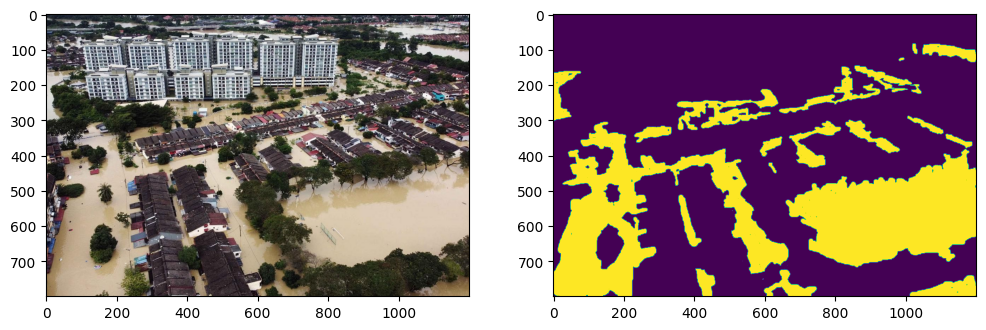

['/kaggle/input/flood-area-segmentation/Image/24.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/24.png']


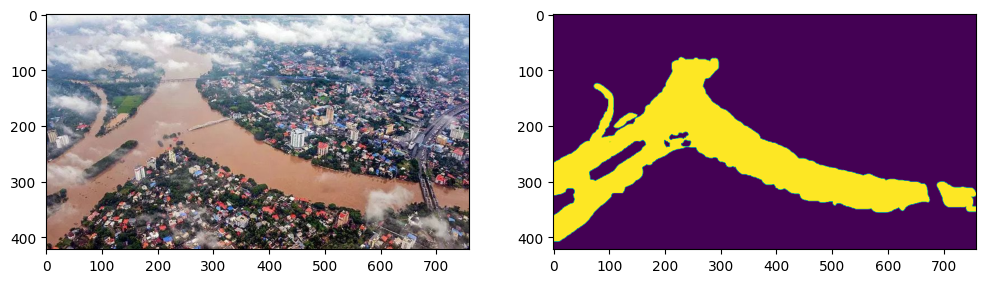

['/kaggle/input/flood-area-segmentation/Image/3059.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/3059.png']


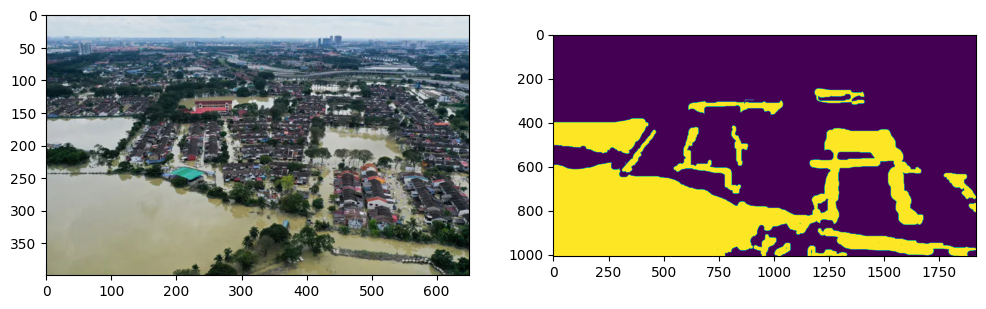

['/kaggle/input/flood-area-segmentation/Image/2040.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/2040.png']


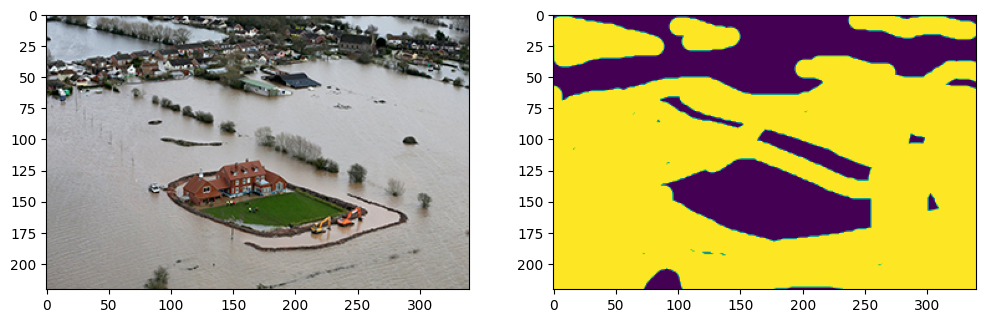

['/kaggle/input/flood-area-segmentation/Image/1073.jpg'] ['/kaggle/input/flood-area-segmentation/Mask/1073.png']


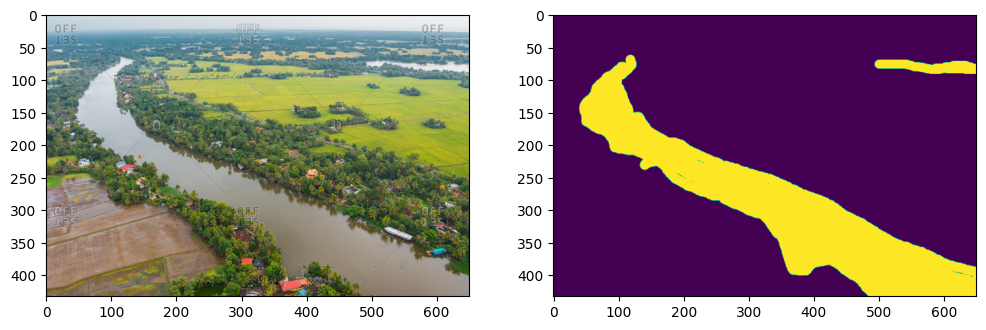

In [ ]:
for i in range(5):
    sample = df.sample(n = 1)
    print(sample['Image'].values, sample['Mask'].values)

    img = plt.imread(sample.iloc[0,0], 0)
    mask = plt.imread(sample.iloc[0, 1], 0)

    plt.figure(figsize = (12,8))
    plt.subplot(1,2,1)
    plt.imshow(img)

    plt.subplot(1,2,2)
    plt.imshow(mask)

    img.shape, mask.shape

    plt.show()

**Image preprocessing**

In [ ]:
IMG_SIZE = (224, 224)

def modify_mask(mask):
    mask = np.expand_dims(mask, axis = 2)
    t_mask = np.zeros(mask.shape)
    np.place(t_mask[:, :, 0], mask[:, :, 0] >=0.5, 1)
    return t_mask

def map_function(img, mask, training):
    img, mask = plt.imread(img.decode())[:, :, :3], plt.imread(mask.decode())
    img = op.resize(img, IMG_SIZE)
    mask = modify_mask(op.resize(mask, IMG_SIZE))

    img = img/255.0
    if training == True:
        transformed = transform(image=img, mask=mask)
        img = transformed['image']
        mask = transformed['mask']

    return img.astype(np.float64), mask.astype(np.float64)

In [ ]:
BATCH_SIZE = 16

def create_dataset(data, training = True):
    dataset = tf.data.Dataset.from_tensor_slices((data['Image'], data['Mask']))
    dataset = dataset.shuffle(100)
    dataset = dataset.map(lambda img, mask : tf.numpy_function(
                    map_function, [img, mask, training], [tf.float64, tf.float64]),
                    num_parallel_calls = tf.data.experimental.AUTOTUNE).batch(BATCH_SIZE)

    dataset = dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(df, test_size = 0.1)

print(df_train.shape, df_test.shape)
train_dataset = create_dataset(df_train, training = True)
test_dataset = create_dataset(df_test, training = False)


(261, 2) (29, 2)


In [ ]:
##The Dice coefficient and Dice loss are often used in segmentation tasks to measure the overlap between the predicted and true segments.
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)

In [ ]:
model = sm.Unet('efficientnetb2',
                input_shape = (224,224,3),
                classes = 1,
                activation='sigmoid',
                encoder_weights='imagenet')

31936256/31936256 [==============================] - 0s 0us/step


In [ ]:
 model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 stem_conv (Conv2D)          (None, 112, 112, 32)         864       ['input_1[0][0]']             
                                                                                                  
 stem_bn (BatchNormalizatio  (None, 112, 112, 32)         128       ['stem_conv[0][0]']           
 n)                                                                                               
                                                                                                  
 stem_activation (Activatio  (None, 112, 112, 32)         0         ['stem_bn[0][0]']         

In [ ]:
model.compile(
    optimizer = keras.optimizers.Adam(learning_rate = 2e-4),
    loss = keras.losses.BinaryCrossentropy(),
    metrics = [sm.metrics.iou_score],
)

In [ ]:
history = model.fit(train_dataset, validation_data = test_dataset, epochs = 50)

Epoch 1/50
17/17 [==============================] - 36s 2s/step - loss: 0.0930 - iou_score: 0.8662 - val_loss: 0.3705 - val_iou_score: 0.7294
Epoch 2/50
17/17 [==============================] - 36s 2s/step - loss: 0.0883 - iou_score: 0.8669 - val_loss: 0.3939 - val_iou_score: 0.7496
Epoch 3/50
17/17 [==============================] - 36s 2s/step - loss: 0.0865 - iou_score: 0.8716 - val_loss: 0.3780 - val_iou_score: 0.7547
Epoch 4/50
17/17 [==============================] - 36s 2s/step - loss: 0.0874 - iou_score: 0.8734 - val_loss: 0.3979 - val_iou_score: 0.7524
Epoch 5/50
17/17 [==============================] - 36s 2s/step - loss: 0.0847 - iou_score: 0.8751 - val_loss: 0.3774 - val_iou_score: 0.7579
Epoch 6/50
17/17 [==============================] - 36s 2s/step - loss: 0.0824 - iou_score: 0.8744 - val_loss: 0.3744 - val_iou_score: 0.7529
Epoch 7/50
17/17 [==============================] - 37s 2s/step - loss: 0.0836 - iou_score: 0.8692 - val_loss: 0.3953 - val_iou_score: 0.7510
Epoch 

<ipython-input-27-9293f450f3f8>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


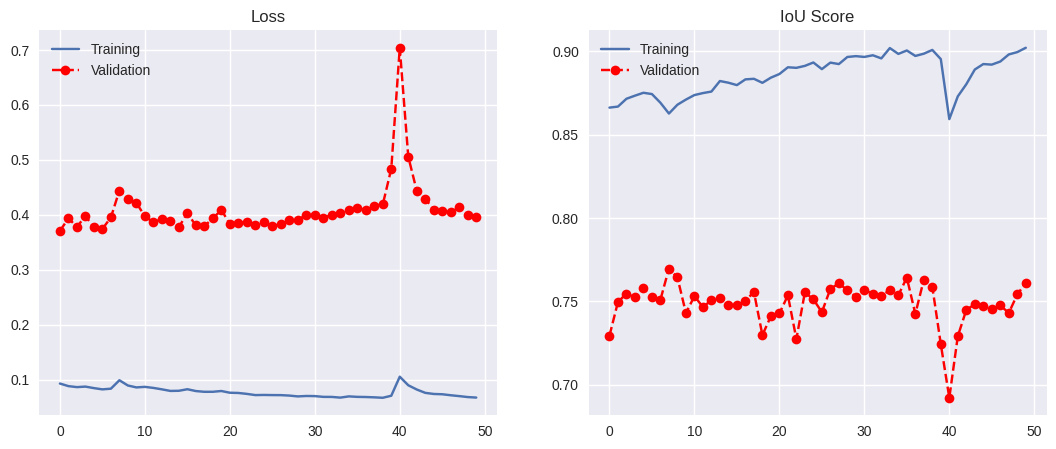

In [ ]:
plt.style.use('seaborn')

plt.figure(figsize = (13,5))
plt.subplot(1,2,1)
plt.title('Loss')
plt.plot(history.history['loss'], label = 'Training')
plt.plot(history.history['val_loss'], '--r', marker = 'o', label = 'Validation')
plt.legend()

plt.subplot(1,2,2)
plt.title('IoU Score')
plt.plot(history.history['iou_score'], label = 'Training')
plt.plot(history.history['val_iou_score'], '--r', marker = 'o', label = 'Validation')
plt.legend()


In [ ]:
color = np.array([161, 205, 255])/255.0

def make_pred_good(pred):
    pred = pred[0][:, :, :]
    pred = modify_mask(pred[:, :, 0])
    pred = np.repeat(pred, 3, 2)
    return pred

def placeMaskOnImg(img, mask):
    np.place(img[:, :, :], mask[:, :, :] >= 0.5, color)
    return img

(-0.5, 223.5, 223.5, -0.5)

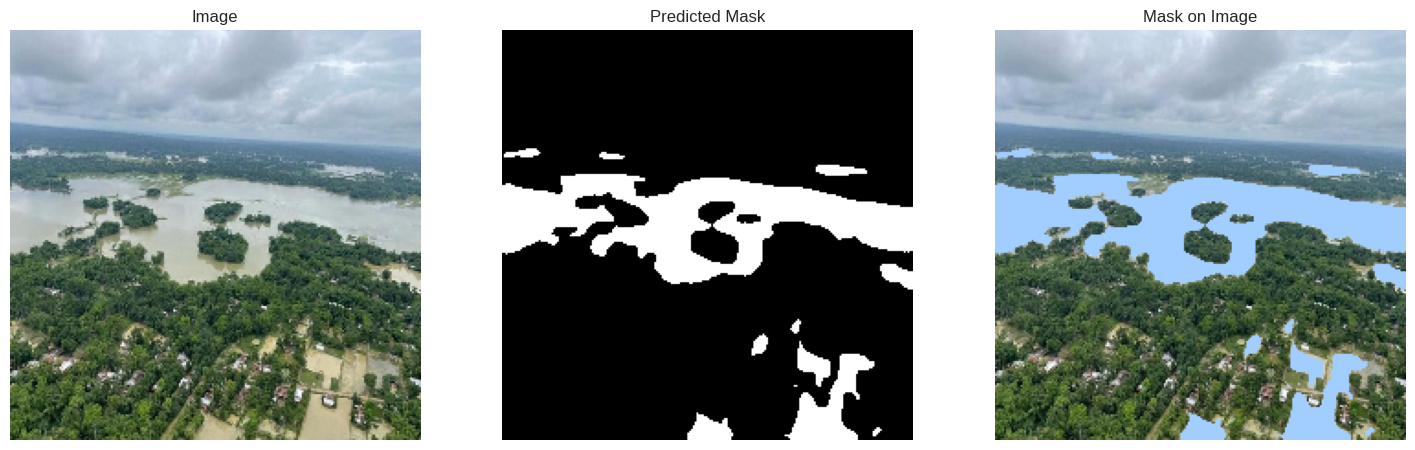

In [ ]:
url ='https://i.tribune.com.pk/media/images/Floods1656337686-1/Floods1656337686-1.jpg'
import requests, io
import numpy as np
from PIL import Image

response = requests.get(url)
bytes_im = io.BytesIO(response.content)
img = np.array(Image.open(bytes_im))[:, :, :3]

img = img/255.0
img = op.resize(img, (224,224))
img = np.expand_dims(img, axis = 0)

plt.figure(figsize = (18, 8))

plt.subplot(1, 3, 1)
plt.title("Image")
plt.imshow(img[0])
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Predicted Mask")
pred = make_pred_good(model(img))
plt.imshow(pred)
plt.axis('off')

plt.subplot(1,3,3)
plt.title("Mask on Image")
plt.imshow(placeMaskOnImg(img[0], pred))
plt.axis('off')

# pred = model(img).numpy()
# plt.imshow(pred.reshape(224, 224))